In [0]:
%matplotlib inline

In [2]:
! pip freeze

beautifulsoup4==4.6.0
bleach==1.5.0
cachetools==2.0.1
certifi==2017.11.5
chardet==3.0.4
crcmod==1.7
cycler==0.10.0
decorator==4.2.1
dill==0.2.7.1
entrypoints==0.2.3
enum34==1.1.6
future==0.15.2
futures==3.0.5
gapic-google-cloud-datastore-v1==0.15.3
gapic-google-cloud-error-reporting-v1beta1==0.15.3
gapic-google-cloud-logging-v2==0.91.3
google-api-core==0.1.4
google-api-python-client==1.6.4
google-auth==1.3.0
google-auth-httplib2==0.0.3
google-auth-oauthlib==0.2.0
google-cloud==0.32.0
google-cloud-bigquery==0.28.0
google-cloud-bigquery-datatransfer==0.1.0
google-cloud-bigtable==0.28.1
google-cloud-container==0.1.0
google-cloud-core==0.28.0
google-cloud-datastore==1.4.0
google-cloud-dns==0.28.0
google-cloud-error-reporting==0.28.0
google-cloud-firestore==0.28.0
google-cloud-language==1.0.0
google-cloud-logging==1.4.0
google-cloud-monitoring==0.28.0
google-cloud-pubsub==0.30.1
google-cloud-resource-manager==0.28.0
google-cloud-runtimeconfig==0.28.0
google-cloud-spanner==0.29.0
google-clou

In [3]:
! pip install http://download.pytorch.org/whl/cu80/torch-0.2.0.post3-cp36-cp36m-manylinux1_x86_64.whl

    100% |████████████████████████████████| 486.7MB 36.8MB/s 


In [4]:
! pip install torchvision==0.1.8


Transfer Learning tutorial
==========================
**Author**: `Sasank Chilamkurthy <https://chsasank.github.io>`_

In this tutorial, you will learn how to train your network using
transfer learning. You can read more about the transfer learning at `cs231n
notes <http://cs231n.github.io/transfer-learning/>`__

Quoting this notes,

    In practice, very few people train an entire Convolutional Network
    from scratch (with random initialization), because it is relatively
    rare to have a dataset of sufficient size. Instead, it is common to
    pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
    contains 1.2 million images with 1000 categories), and then use the
    ConvNet either as an initialization or a fixed feature extractor for
    the task of interest.

These two major transfer learning scenarios looks as follows:

-  **Finetuning the convnet**: Instead of random initializaion, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.




In [0]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

Load Data
---------

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet.

.. Note ::
   Download the data from
   `here <https://download.pytorch.org/tutorial/hymenoptera_data.zip>`_
   and extract it to the current directory.



In [6]:
! wget -O hymenoptera_data.zip "https://download.pytorch.org/tutorial/hymenoptera_data.zip"

--2018-01-23 12:25:29--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 54.192.81.65, 54.192.81.80, 54.192.81.161, ...
Connecting to download.pytorch.org (download.pytorch.org)|54.192.81.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  21.3MB/s    in 2.1s    

2018-01-23 12:25:32 (21.3 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



In [7]:
! unzip hymenoptera_data.zip

Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data/train/ants/116570827_e9c126745d.jpg  
  inflating: hymenoptera_data/train/ants/1225872729_6f0856588f.jpg  
  inflating: hymenoptera_data/train/ants/1262877379_64fcada201.jpg  
  inflating: hymenoptera_data/train/ants/1269756697_0bce92cdab.jpg  
  inflating: hymenoptera_data/train/ants/1286984635_5119e80de1.jpg  
  inflating: hymenoptera_data/train/ants/132478121_2a430adea2.jpg  
  inflating: hymenoptera_data/train/ants/1360291657_dc248c5eea.jpg  
  inflating: hymenoptera_data/train/ants/1368913450_e146e2fb6d.jpg  
  inflating: hymenoptera_data/train/ants/147318


  inflating: hymenoptera_data/val/bees/203868383_0fcbb48278.jpg  
  inflating: hymenoptera_data/val/bees/2060668999_e11edb10d0.jpg  
  inflating: hymenoptera_data/val/bees/2086294791_6f3789d8a6.jpg  
  inflating: hymenoptera_data/val/bees/2103637821_8d26ee6b90.jpg  
  inflating: hymenoptera_data/val/bees/2104135106_a65eede1de.jpg  
  inflating: hymenoptera_data/val/bees/215512424_687e1e0821.jpg  
  inflating: hymenoptera_data/val/bees/2173503984_9c6aaaa7e2.jpg  
  inflating: hymenoptera_data/val/bees/220376539_20567395d8.jpg  
  inflating: hymenoptera_data/val/bees/224841383_d050f5f510.jpg  
  inflating: hymenoptera_data/val/bees/2321144482_f3785ba7b2.jpg  
  inflating: hymenoptera_data/val/bees/238161922_55fa9a76ae.jpg  
  inflating: hymenoptera_data/val/bees/2407809945_fb525ef54d.jpg  
  inflating: hymenoptera_data/val/bees/2415414155_1916f03b42.jpg  
  inflating: hymenoptera_data/val/bees/2438480600_40a1249879.jpg  
  inflating: hymenoptera_data/val/bees/2444778727_4b781ac424.jpg  

In [8]:
! ls

datalab  hymenoptera_data  hymenoptera_data.zip


In [0]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

Visualize a few images
^^^^^^^^^^^^^^^^^^^^^^
Let's visualize a few training images so as to understand the data
augmentations.



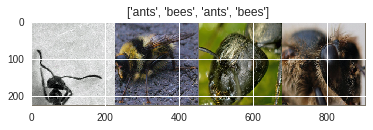

In [10]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0] * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Visualizing the model predictions
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Generic function to display predictions for a few images




In [0]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [13]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /content/.torch/models/resnet18-5c106cde.pth
13.9%

100.0%


Train and evaluate
^^^^^^^^^^^^^^^^^^

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [14]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6174 Acc: 0.7172
val Loss: 0.2596 Acc: 0.8758

Epoch 1/24
----------
train Loss: 0.5119 Acc: 0.7582
val Loss: 0.3360 Acc: 0.8627

Epoch 2/24
----------
train Loss: 0.4663 Acc: 0.8115
val Loss: 0.5860 Acc: 0.7908

Epoch 3/24
----------
train Loss: 0.5419 Acc: 0.7664
val Loss: 0.3667 Acc: 0.8431

Epoch 4/24
----------
train Loss: 0.6352 Acc: 0.7828
val Loss: 0.4877 Acc: 0.8497

Epoch 5/24
----------
train Loss: 0.4396 Acc: 0.8566
val Loss: 0.3726 Acc: 0.8954

Epoch 6/24
----------
train Loss: 0.4490 Acc: 0.8279
val Loss: 0.3436 Acc: 0.8366

Epoch 7/24
----------
train Loss: 0.3691 Acc: 0.8320
val Loss: 0.3001 Acc: 0.8824

Epoch 8/24
----------
train Loss: 0.3389 Acc: 0.8648
val Loss: 0.3045 Acc: 0.8824

Epoch 9/24
----------
train Loss: 0.3975 Acc: 0.8361
val Loss: 0.2776 Acc: 0.9020

Epoch 10/24
----------
train Loss: 0.3704 Acc: 0.8361
val Loss: 0.2649 Acc: 0.9085

Epoch 11/24
----------
train Loss: 0.4315 Acc: 0.8279
val Loss: 0.2676 Acc: 0.9150

Ep

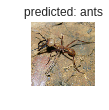

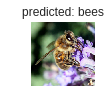

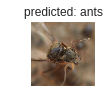

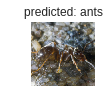

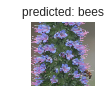

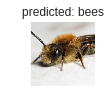

In [15]:
visualize_model(model_ft)

ConvNet as fixed feature extractor
----------------------------------

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
`here <http://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.




In [0]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_conv = model_conv.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Train and evaluate
^^^^^^^^^^^^^^^^^^

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [17]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6251 Acc: 0.6967
val Loss: 0.4889 Acc: 0.7320

Epoch 1/24
----------
train Loss: 0.4198 Acc: 0.8033
val Loss: 0.2074 Acc: 0.9281

Epoch 2/24
----------
train Loss: 0.3666 Acc: 0.8443
val Loss: 0.2191 Acc: 0.9281

Epoch 3/24
----------
train Loss: 0.4716 Acc: 0.8156
val Loss: 0.1821 Acc: 0.9346

Epoch 4/24
----------
train Loss: 0.4859 Acc: 0.7869
val Loss: 0.2579 Acc: 0.9150

Epoch 5/24
----------
train Loss: 0.4337 Acc: 0.7992
val Loss: 0.3623 Acc: 0.8693

Epoch 6/24
----------
train Loss: 0.4304 Acc: 0.8279
val Loss: 0.1699 Acc: 0.9412

Epoch 7/24
----------
train Loss: 0.2908 Acc: 0.8893
val Loss: 0.1726 Acc: 0.9608

Epoch 8/24
----------
train Loss: 0.3006 Acc: 0.8607
val Loss: 0.2059 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.2993 Acc: 0.8566
val Loss: 0.1715 Acc: 0.9608

Epoch 10/24
----------
train Loss: 0.4146 Acc: 0.8033
val Loss: 0.1680 Acc: 0.9542

Epoch 11/24
----------
train Loss: 0.3275 Acc: 0.8648
val Loss: 0.1595 Acc: 0.9608

Ep

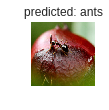

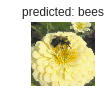

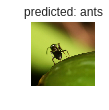

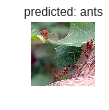

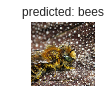

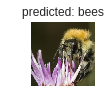

In [18]:
visualize_model(model_conv)

plt.ioff()
plt.show()

One can also extract features from resnet18 and save it in .txt file for other explorations.

In [19]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
print(num_ftrs)

512


In [20]:
print(model_ft)

ResNet (
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU (inplace)
  (maxpool): MaxPool2d (size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (layer1): Sequential (
    (0): BasicBlock (
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock (
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d

Now extract 512-features as the network output after removing the last fc layer.

In [21]:
modules = list(model_ft.children())[:-1]
resnet18_feature = nn.Sequential(*modules)

inputs, classes = next(iter(dataloaders['val']))
print(classes)


 1
 1
 1
 1
[torch.LongTensor of size 4]



In [22]:
inputs, labels = Variable(inputs), Variable(classes)
outputs = resnet18_feature(inputs)

outputs.size()

torch.Size([4, 512, 1, 1])

Reshape the torch tensor to be a matrix of nsample-by-nfeature:

In [23]:
out1 = outputs.resize(4,512)
out1.size()

torch.Size([4, 512])

In [31]:
out1_array = np.array(out1)
out1_array.shape

(4,
 512,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1)

In [0]:
np.save('resnet18_ft',out1_array)

In [0]:
X = np.load('resnet18_ft.npy')

In [42]:
X.shape

(4,
 512,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1)